## VAE vs CVAE

Реализованы модели VAE и Conditional VAE вместе. Для создания CVAE необходимо указать при инициализации conditional=True и число меток.

In [0]:
import os
import time
import torch
import argparse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from collections import defaultdict

In [2]:
!pip install YaDiskClient
from YaDiskClient.YaDiskClient import YaDisk
disk = YaDisk('np2018pletnev', 'P1a2S3s4W5o6R7d8')
disk.ls('/Питон')
disk.download('/Питон/CVAE.py', './CVAE.py')

  Created wheel for YaDiskClient: filename=YaDiskClient-0.5.0-cp36-none-any.whl size=5186 sha256=e5c6fc6ebe8298f585194c06335dcb4fe72a7e0a407e1e9b230186689044e815
  Stored in directory: /root/.cache/pip/wheels/85/61/2b/145151b370ab516f39b8390fa6d0f967a333293c17e4b78de7
Successfully built YaDiskClient


In [0]:
from CVAE import VAE

In [0]:
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
dataset = MNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset=dataset, batch_size=64, shuffle=True)

  0%|          | 16384/9912422 [00:00<01:16, 129850.49it/s]

100%|█████████▉| 9895936/9912422 [00:56<00:00, 132169.95it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



0it [00:00, ?it/s]
32768it [00:00, 348347.10it/s]
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



 99%|█████████▉| 1638400/1648877 [00:08<00:00, 208929.36it/s]

0it [00:00, ?it/s]

8192it [00:00, 176304.14it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


In [0]:
def loss_fn(recon_x, x, mean, log_var):
    BCE = torch.nn.functional.binary_cross_entropy(recon_x.view(-1, 28*28), x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return (BCE + KLD) / x.size(0)

In [0]:
vae = VAE(
        encoder_layer_sizes=[784, 256],
        latent_size=2,
        decoder_layer_sizes=[256, 784],
        conditional=True,
        num_labels=10).to(device)

In [0]:
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)

In [0]:
logs = defaultdict(list)

In [0]:
fig_root = 'figs'
epochs = 30
freq_print = 100

Epoch 00/30 Batch 0000/937, Loss  545.5496
Epoch 00/30 Batch 0100/937, Loss  195.3215


9920512it [01:10, 132169.95it/s]                             

Epoch 00/30 Batch 0200/937, Loss  174.7155
Epoch 00/30 Batch 0300/937, Loss  162.8347
Epoch 00/30 Batch 0400/937, Loss  160.7880



1654784it [00:22, 208929.36it/s]                             

Epoch 00/30 Batch 0500/937, Loss  150.3710
Epoch 00/30 Batch 0600/937, Loss  153.5373
Epoch 00/30 Batch 0700/937, Loss  154.4583
Epoch 00/30 Batch 0800/937, Loss  142.2378
Epoch 00/30 Batch 0900/937, Loss  142.3728
Epoch 00/30 Batch 0937/937, Loss  142.1745
Epoch 01/30 Batch 0000/937, Loss  148.2435
Epoch 01/30 Batch 0100/937, Loss  153.0368
Epoch 01/30 Batch 0200/937, Loss  142.9212
Epoch 01/30 Batch 0300/937, Loss  146.0695
Epoch 01/30 Batch 0400/937, Loss  119.3645
Epoch 01/30 Batch 0500/937, Loss  137.7091
Epoch 01/30 Batch 0600/937, Loss  136.7799
Epoch 01/30 Batch 0700/937, Loss  142.7684
Epoch 01/30 Batch 0800/937, Loss  143.3371
Epoch 01/30 Batch 0900/937, Loss  137.2326
Epoch 01/30 Batch 0937/937, Loss  131.5324
Epoch 02/30 Batch 0000/937, Loss  139.6454
Epoch 02/30 Batch 0100/937, Loss  145.6073
Epoch 02/30 Batch 0200/937, Loss  139.7712
Epoch 02/30 Batch 0300/937, Loss  140.1827
Epoch 02/30 Batch 0400/937, Loss  135.7640
Epoch 02/30 Batch 0500/937, Loss  138.9347
Epoch 02/30

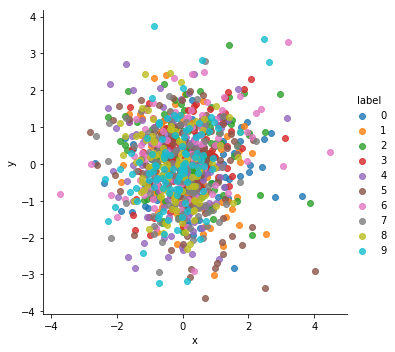

In [11]:
ts = time.time()
for epoch in range(epochs):
    tracker_epoch = defaultdict(lambda: defaultdict(dict))
    for iteration, (x, y) in enumerate(data_loader):
        x, y = x.to(device), y.to(device)
        recon_x, mean, log_var, z = vae(x, y) # conditional
        #recon_x, mean, log_var, z = vae(x) # without condition
        for i, yi in enumerate(y):
            id = len(tracker_epoch)
            tracker_epoch[id]['x'] = z[i, 0].item()
            tracker_epoch[id]['y'] = z[i, 1].item()
            tracker_epoch[id]['label'] = yi.item()

        loss = loss_fn(recon_x, x, mean, log_var)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        logs['loss'].append(loss.item())

        if iteration % freq_print == 0 or iteration == len(data_loader)-1:
            print("Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss {:9.4f}".format(
                epoch, epochs, iteration, len(data_loader)-1, loss.item()))

            # conditional
            c = torch.arange(0, 10).long().unsqueeze(1)
            x = vae.inference(n=c.size(0), c=c)
            # without condition
            # x = vae.inference(n=10)

            plt.figure()
            plt.figure(figsize=(5, 10))
            for p in range(10):
                plt.subplot(5, 2, p+1)
                # conditional
                plt.text(0, 0, "c={:d}".format(c[p].item()), color='black',
                        backgroundcolor='white', fontsize=8)
                plt.imshow(x[p].view(28, 28).data.numpy())
                plt.axis('off')

            if not os.path.exists(os.path.join(fig_root, str(ts))):
                if not(os.path.exists(os.path.join(fig_root))):
                    os.mkdir(os.path.join(fig_root))
                os.mkdir(os.path.join(fig_root, str(ts)))

            plt.savefig(os.path.join(fig_root, str(ts),
                        "E{:d}I{:d}.png".format(epoch, iteration)), dpi=300)
            plt.clf()
            plt.close('all')

    df = pd.DataFrame.from_dict(tracker_epoch, orient='index')
    g = sns.lmplot(x='x', y='y', hue='label', 
                   data=df.groupby('label').head(100), 
                   fit_reg=False, legend=True)
    g.savefig(os.path.join(fig_root, str(ts), 
                           "E{:d}-Dist.png".format(epoch)), dpi=300)


In [0]:
vae_unc = VAE(
        encoder_layer_sizes=[784, 256],
        latent_size=2,
        decoder_layer_sizes=[256, 784],
        conditional=False).to(device)

In [0]:
optimizer = torch.optim.Adam(vae.parameters(), lr=0.01)

Epoch 00/30 Batch 0000/937, Loss  553.3519
Epoch 00/30 Batch 0100/937, Loss  553.1036
Epoch 00/30 Batch 0200/937, Loss  553.9913
Epoch 00/30 Batch 0300/937, Loss  552.0281
Epoch 00/30 Batch 0400/937, Loss  553.4207
Epoch 00/30 Batch 0500/937, Loss  553.2253
Epoch 00/30 Batch 0600/937, Loss  554.4205
Epoch 00/30 Batch 0700/937, Loss  553.3081
Epoch 00/30 Batch 0800/937, Loss  553.6992
Epoch 00/30 Batch 0900/937, Loss  553.4815
Epoch 00/30 Batch 0937/937, Loss  555.3690
Epoch 01/30 Batch 0000/937, Loss  553.0424
Epoch 01/30 Batch 0100/937, Loss  556.1573
Epoch 01/30 Batch 0200/937, Loss  553.6932
Epoch 01/30 Batch 0300/937, Loss  553.8049
Epoch 01/30 Batch 0400/937, Loss  553.7382
Epoch 01/30 Batch 0500/937, Loss  553.4617
Epoch 01/30 Batch 0600/937, Loss  552.3068
Epoch 01/30 Batch 0700/937, Loss  552.9987
Epoch 01/30 Batch 0800/937, Loss  552.7238
Epoch 01/30 Batch 0900/937, Loss  552.5312
Epoch 01/30 Batch 0937/937, Loss  552.5608
Epoch 02/30 Batch 0000/937, Loss  553.3448
Epoch 02/30

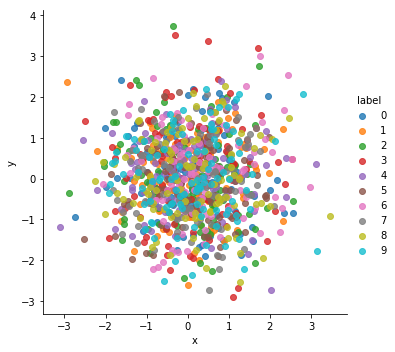

In [33]:
ts = time.time()
for epoch in range(epochs):
    tracker_epoch = defaultdict(lambda: defaultdict(dict))
    for iteration, (x, y) in enumerate(data_loader):
        x, y = x.to(device), y.to(device)
        #recon_x, mean, log_var, z = vae(x, y) # conditional
        recon_x, mean, log_var, z = vae_unc(x) # without condition
        for i, yi in enumerate(y):
            id = len(tracker_epoch)
            tracker_epoch[id]['x'] = z[i, 0].item()
            tracker_epoch[id]['y'] = z[i, 1].item()
            tracker_epoch[id]['label'] = yi.item()

        loss = loss_fn(recon_x, x, mean, log_var)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        logs['loss'].append(loss.item())

        if iteration % freq_print == 0 or iteration == len(data_loader)-1:
            print("Epoch {:02d}/{:02d} Batch {:04d}/{:d}, Loss {:9.4f}".format(
                epoch, epochs, iteration, len(data_loader)-1, loss.item()))

            # conditional
            # c = torch.arange(0, 10).long().unsqueeze(1)
            # x = vae.inference(n=c.size(0), c=c)
            # without condition
            x = vae_unc.inference(n=10)

            plt.figure()
            plt.figure(figsize=(5, 10))
            for p in range(10):
                plt.subplot(5, 2, p+1)
                # conditional
                plt.text(0, 0, "c={:d}".format(c[p].item()), color='black',
                        backgroundcolor='white', fontsize=8)
                plt.imshow(x[p].view(28, 28).data.numpy())
                plt.axis('off')

            if not os.path.exists(os.path.join(fig_root, str(ts))):
                if not(os.path.exists(os.path.join(fig_root))):
                    os.mkdir(os.path.join(fig_root))
                os.mkdir(os.path.join(fig_root, str(ts)))

            plt.savefig(os.path.join(fig_root, str(ts),
                        "E{:d}I{:d}.png".format(epoch, iteration)), dpi=300)
            plt.clf()
            plt.close('all')

    df = pd.DataFrame.from_dict(tracker_epoch, orient='index')
    g = sns.lmplot(x='x', y='y', hue='label', 
                   data=df.groupby('label').head(100), 
                   fit_reg=False, legend=True)
    g.savefig(os.path.join(fig_root, str(ts), 
                           "E{:d}-Dist.png".format(epoch)), dpi=300)


In [0]:
def recursive_upload(yadisk, folder):
    try:
        yadisk.upload(folder, folder)
    except IsADirectoryError:
        yadisk.mkdir(folder)
        content = os.listdir(folder)
        for obj in content:
            recursive_upload(yadisk, folder+os.sep+obj)

In [0]:
recursive_upload(disk, "figs")